# Image classification with MLPs


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

*Drew Cohen acohen24@tufts.edu*

------------------------------------------------------


In this lab, you will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

In [24]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [26]:
### Run this cell

from torchvision import datasets, transforms

# Define a thresholding function
def binarize(image, threshold=0.5):
    return (image > threshold).float()  # Convert to 1 if above threshold, else 0

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              transforms.Lambda(lambda img: binarize(img, threshold=0.0))  # Apply binarization
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [27]:
# RUN THIS CELL INSTEAD TO RESIZE THE DATA

# Define a thresholding function
def binarize(image, threshold=0.5):
    return (image > threshold).float()  # Convert to 1 if above threshold, else 0

new_size = (28, 28)  # Set your desired resolution
resize_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,)),
                                       transforms.Resize(new_size),
                                       transforms.Lambda(lambda img: binarize(img, threshold=0.0))  # Apply binarization
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=resize_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=resize_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [28]:
# def convert_to_half(batch):
#     inputs, targets = batch
#     return inputs.half(), targets  # Convert inputs to float16, but keep targets unchanged

# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=64, shuffle=True, collate_fn=convert_to_half
# )

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to **shuffle the dataset every time we start going through the data loader again**. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [29]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like.

tensor(7)


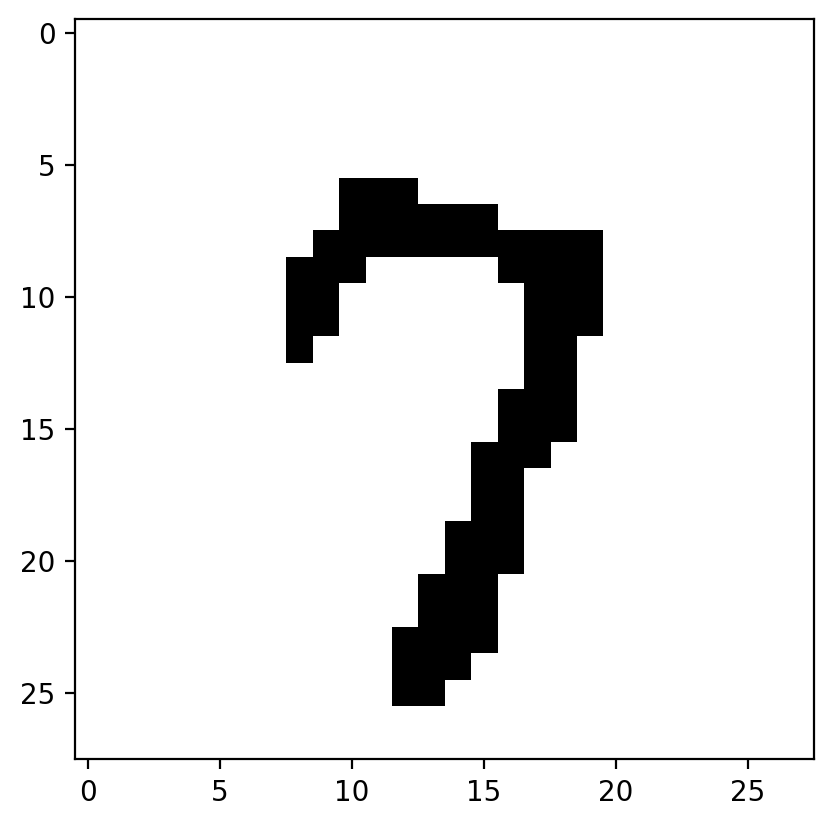

In [31]:
plt.imshow(images[0].numpy().reshape([28,28]), cmap='binary')
print(labels[0])

## Part II. Train a multi-class Logistic Regressor

Our first goal is to train a multi-class logistic regressor to evaluate how good it can do in both the training and the test sets.

The following code is **almost identical** to the one you used for Lab 1 except for two small details:

- We are training a LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid).

- We are using the MNIST database loaded above.

We first define the Multi-class Logistic Regressor class

> **Exercise**: Complete the following code

In [38]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        self.output = nn.Linear(dimx,nlabels)


        self.logsoftmax = nn.LogSoftmax(dim=1)   # NEW w.r.t Lab 1. dim is the dimension along which
                                                 #Softmax will be computed (so every slice along dim will sum to 1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.logsoftmax(x)
        return x

Note that we use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, we can use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor.

> **Exercise**: Complete the following code

In [64]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add.
'''
class Multi_LR_extended(Multi_LR):

    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1

        # A list to store the loss evolution along training

        self.loss_during_training = []

    def train(self,trainloader):

        # Optimization Loop

        for e in range(int(self.epochs)):

            # Random data permutation at each epoch

            running_loss = 0.

            for images, labels in trainloader:              # NEW w.r.t Lab 1
                # For halving the model !!
                images = images.to(torch.float16)  # Convert images to float16
                labels = labels.to(torch.int64)   # Keep labels as int64 (required for classification)

                self.optim.zero_grad()  #TO RESET GRADIENTS!


                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()

                #Your code here
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))


Ok that was easy, wasn't it? Lets now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [40]:
my_LR = Multi_LR_extended(dimx=3072,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)


Training loss after 0 epochs: 0.386752
Training loss after 1 epochs: 0.291506
Training loss after 2 epochs: 0.272891
Training loss after 3 epochs: 0.261150
Training loss after 4 epochs: 0.253084


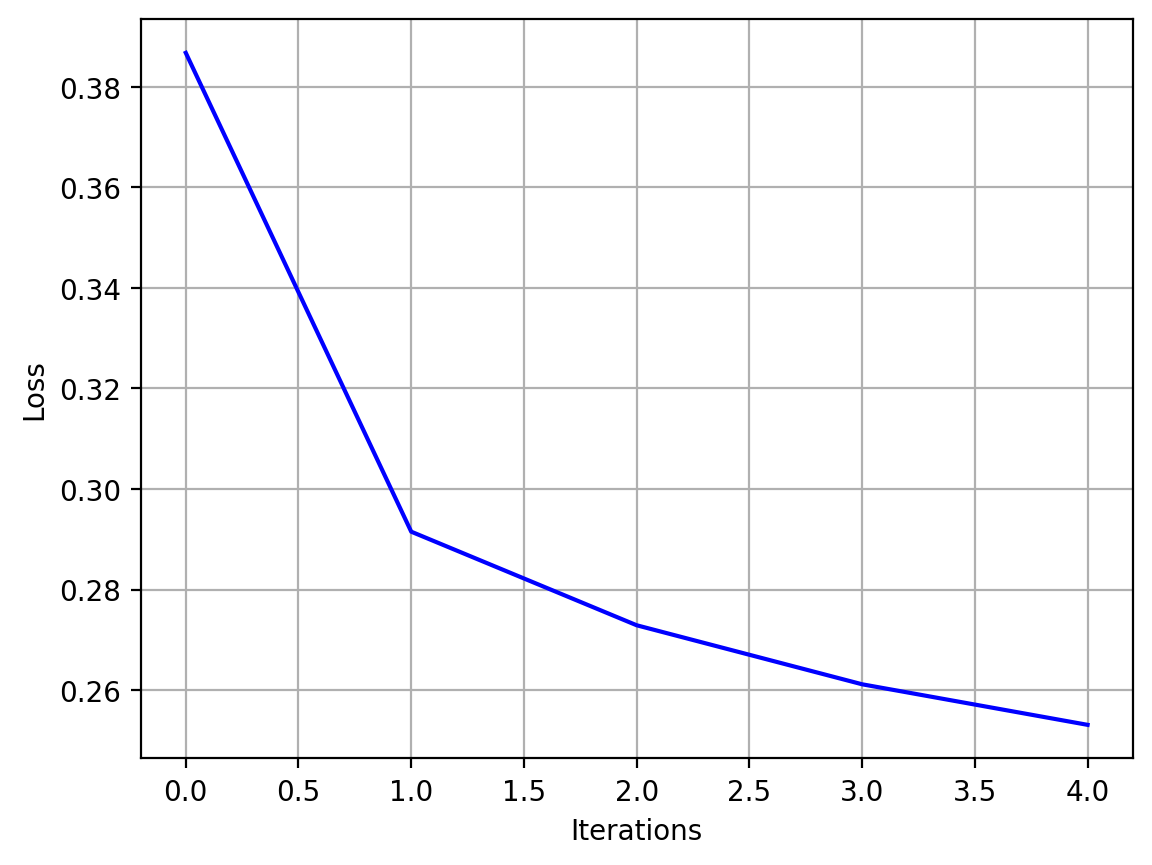

In [41]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [42]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:

        logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities

        top_p, top_class = logprobs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))


print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.923567


With the probabilities, we can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting whether `top_class` is equal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean using `torch.mean()`.

> **Excercise** Modify the code of the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set (Use a single method with the proper inputs!)

In [43]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add.
'''
class Multi_LR_extended2(Multi_LR):

    #Your code here

    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()              # NEW w.r.t Lab 1

        # A list to store the loss evolution along training

        self.loss_during_training = []

    def train(self,trainloader):

        # Optimization Loop

        for e in range(int(self.epochs)):

            # Random data permutation at each epoch

            running_loss = 0.

            for images, labels in trainloader:              # NEW w.r.t Lab 1

                self.optim.zero_grad()  #TO RESET GRADIENTS!

                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()

                #Your code here
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))

    def eval_performance(self,dataloader):


        #YOUR CODE HERE


        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

In [62]:
my_LR = Multi_LR_extended2(dimx=3072,nlabels=10,epochs=10,lr=1e-3)

my_LR.train(trainloader)

train_performance = my_LR.eval_performance(trainloader)

test_performance = my_LR.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

KeyboardInterrupt: 

Observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

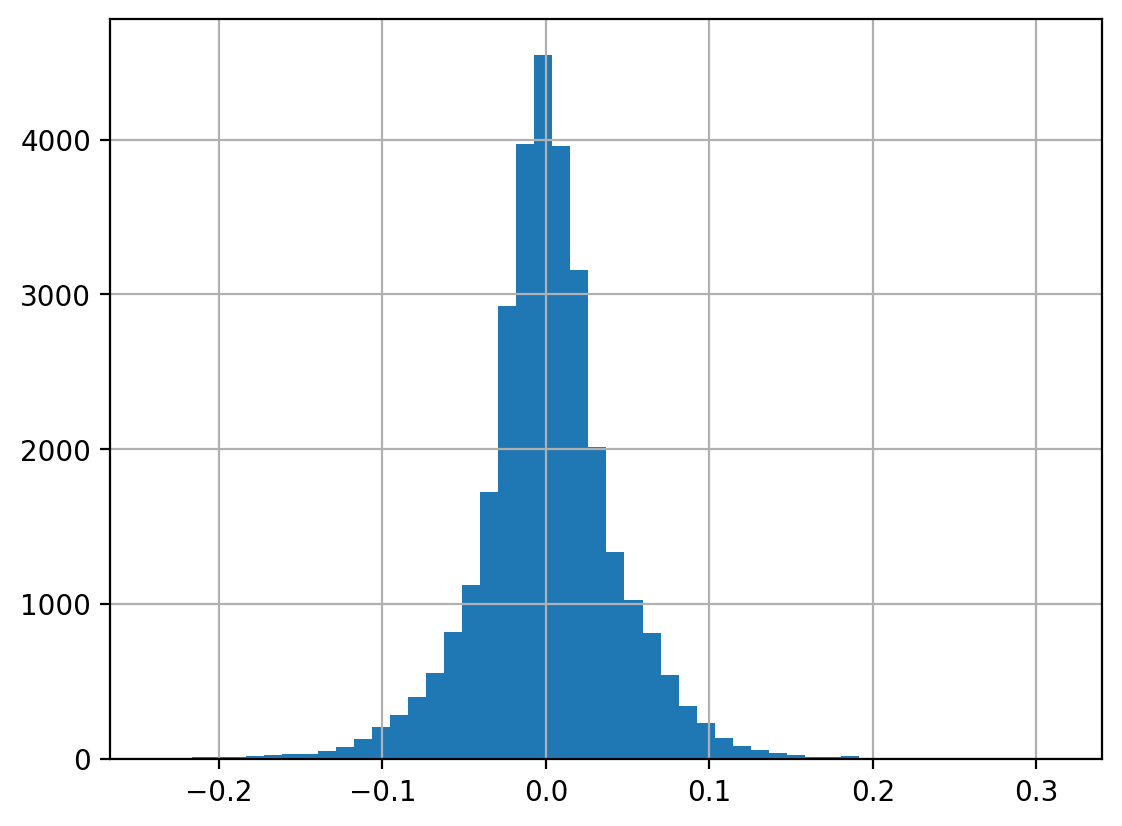

In [14]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50)
plt.grid()

> **Exercise**: Plot the histogram of the gradient of the loss function w.r.t. every parameter in the model:

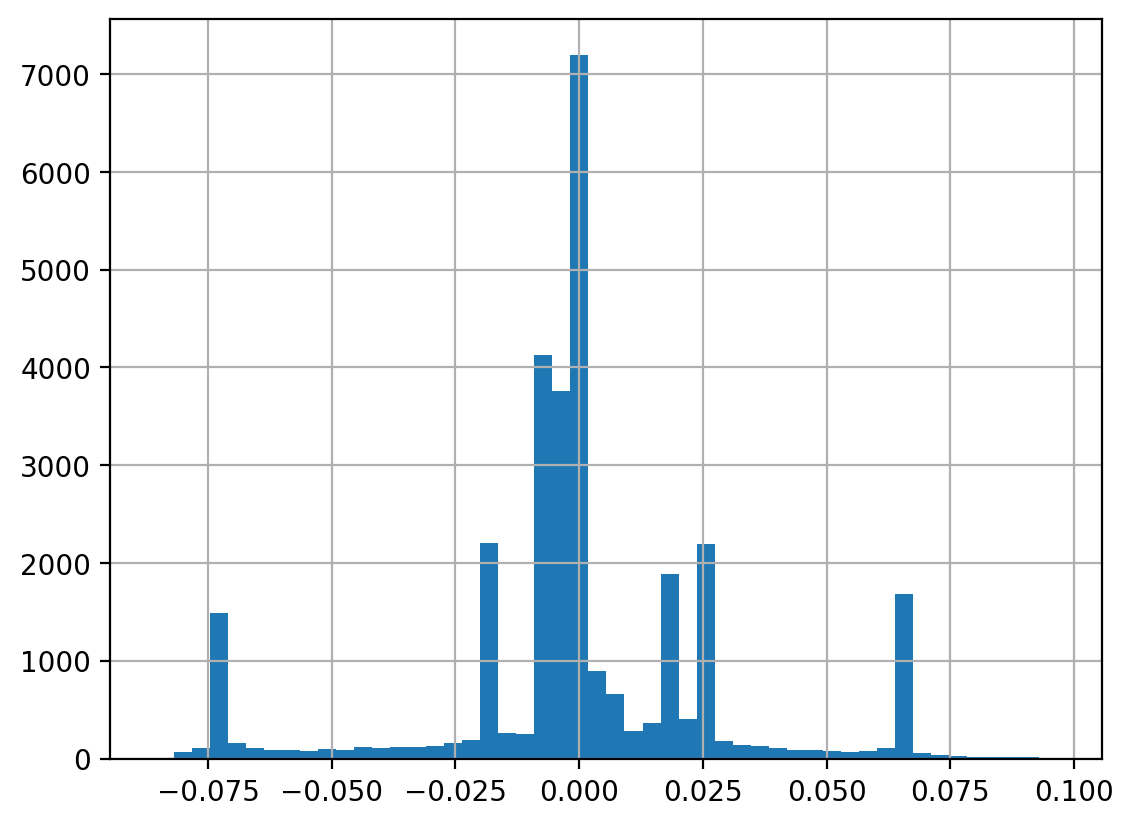

In [15]:
#YOUR CODE HERE

plt.hist(my_LR.output.weight.grad.detach().numpy().reshape([-1,]),50)
plt.grid()

As we can see most of the gradients are almost zero

## Part III. Train a MLP to do the same job

Modify the code you have just implemented for a MLP is straightforward. Assume we want to train a MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer, that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [32]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.

> **Exercise**: Complete the code for the following class

In [33]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

> **Excercise** Create a class `MLP_extended` that incorporates two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the code you have done above for the multi-class LR. This is why I like class and structure my code this way!!

In [34]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add.
'''
class MLP_extended(MLP):

    #Your code here

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

    def train(self,trainloader):

        # Optimization Loop

        for e in range(int(self.epochs)):

            # Random data permutation at each epoch

            running_loss = 0.

            for images, labels in trainloader:              # NEW w.r.t Lab 1

                self.optim.zero_grad()  #TO RESET GRADIENTS!


                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()

                #Your code here
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))


    def eval_performance(self,dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

In [35]:
# NEW FOR HALVING MODEL -- not great bc we see numerical instability with float16

''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add.
'''
class MLP_extended(MLP):

    #Your code here

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

    def train(self, trainloader):
        self = self.half()  # Convert model weights to float16

        for e in range(int(self.epochs)):
            running_loss = 0.

            for images, labels in trainloader:
                images = images.half()  # Convert inputs to float16
                labels = labels.long()  # Ensure labels are int64 for loss function

                self.optim.zero_grad()

                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)

                if torch.isnan(loss):  # Debugging: Check for NaN loss
                    print("NaN detected in loss! Skipping step...")
                    continue  # Skip this batch

                running_loss += loss.item()

                loss.backward()

                # 🔹 Clip gradients to prevent instability
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            print(f"Training loss after {e} epochs: {self.loss_during_training[-1]:.6f}")


    def eval_performance(self, dataloader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.half()  # Convert input images to float16
                labels = labels.long()  # Ensure labels are int64

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))

                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy / len(dataloader)


In [86]:
# SECOND ATTEMPT AT HALVING MODEL -- using bfloat16 instead of float16

''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add.
'''
class MLP_extended(MLP):

    #Your code here

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

    def train(self, trainloader):
        self = self.to(dtype=torch.bfloat16)  # Convert model weights to bfloat16

        for e in range(int(self.epochs)):
            running_loss = 0.

            for images, labels in trainloader:
                images = images.to(dtype=torch.bfloat16)  # Convert inputs to bfloat16
                labels = labels.long()  # Ensure labels are int64 for loss function

                self.optim.zero_grad()

                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)

                if torch.isnan(loss):  # Debugging: Check for NaN loss
                    print("NaN detected in loss! Skipping step...")
                    continue  # Skip this batch

                running_loss += loss.item()

                loss.backward()

                # 🔹 Clip gradients to prevent instability
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            print(f"Training loss after {e} epochs: {self.loss_during_training[-1]:.6f}")



    def eval_performance(self, dataloader):
        accuracy = 0

        # Convert model to bfloat16
        self = self.to(dtype=torch.bfloat16)  # Convert model weights to bfloat16

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(dtype=torch.bfloat16)  # Convert input images to bfloat16
                labels = labels.long()  # Ensure labels are int64 for loss function

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))

                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy / len(dataloader)


In [ ]:
# Now initialize the model, prepare for quantization and train
my_MLP = MLP_extended(dimx=3072, hidden1=16, hidden2=8, nlabels=10, epochs=2, lr=1e-3)

# Train the model
quantized_model = my_MLP.train(trainloader)

# Evaluate the performance on train and test data
train_performance = my_MLP.eval_performance(trainloader)
test_performance = my_MLP.eval_performance(testloader)

print(f"Train Accuracy: {train_performance}")
print(f"Test Accuracy: {test_performance}")

Train the model for 10 epochs and compute the train/test performance. Then plot the loss during trianing. How does it compare with the Logistic Regressor?

In [ ]:
my_MLP = MLP_extended(dimx=3072,hidden1=16,hidden2=8,nlabels=10,epochs=0,lr=1e-3)

my_MLP.train(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))



Train Accuracy 0.099147
Test Accuracy 0.100717


In [116]:
# Print weights of quantized model
for name, param in my_MLP.named_parameters():
    if 'weight' in name:
        print(f"Layer: {name}, Weights: {param}")

Layer: output1.weight, Weights: Parameter containing:
tensor([[-0.0121, -0.0055, -0.0120,  ...,  0.0033, -0.0129,  0.0024],
        [ 0.0042, -0.0109,  0.0029,  ..., -0.0042,  0.0057,  0.0096],
        [ 0.0036, -0.0112, -0.0084,  ..., -0.0084, -0.0063,  0.0165],
        ...,
        [ 0.0099,  0.0030,  0.0164,  ..., -0.0095,  0.0083, -0.0025],
        [-0.0040,  0.0162,  0.0043,  ..., -0.0078, -0.0050,  0.0041],
        [-0.0165, -0.0066, -0.0140,  ...,  0.0138, -0.0095,  0.0031]],
       dtype=torch.bfloat16, requires_grad=True)
Layer: output2.weight, Weights: Parameter containing:
tensor([[-0.1934,  0.0150, -0.2100, -0.2012, -0.1660,  0.1641,  0.1396,  0.1094,
          0.1387,  0.0150,  0.2314, -0.2266,  0.1543, -0.0588, -0.1270,  0.2061],
        [-0.0518, -0.2461, -0.1953,  0.0537,  0.1475, -0.1484,  0.0688, -0.0312,
          0.0359,  0.0142,  0.0435, -0.0374,  0.0869, -0.1455,  0.0093,  0.2334],
        [-0.1123,  0.0698,  0.2197,  0.1895, -0.1348,  0.1128, -0.1128,  0.1089,
  

In [241]:
# Quantization for 8-bit weights

import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quant

class QuantizedMLP(nn.Module):
    def __init__(self, dimx, hidden1, hidden2, nlabels):
        super().__init__()

        # Create sequential model for proper quantization
        self.quant = torch.quantization.QuantStub()

        # First layer
        self.layer1 = nn.Sequential(
            nn.Linear(dimx, hidden1),
            nn.ReLU()
        )

        # Second layer
        self.layer2 = nn.Sequential(
            nn.Linear(hidden1, hidden2),
            nn.ReLU()
        )

        # Output layer
        self.layer3 = nn.Sequential(
            nn.Linear(hidden2, nlabels),
            nn.LogSoftmax(dim=1)
        )

        self.dequant = torch.quantization.DeQuantStub()

        # Set quantization configuration
        self.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    def forward(self, x):
        # Flatten (except batch dimension)
        x = x.view(x.shape[0], -1)  # Reshapes from (64, 1, 48, 64) → (64, 3072)

        x = self.quant(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dequant(x)
        return x

class MLP_extended(MLP):
    def __init__(self, dimx, hidden1, hidden2, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, hidden1, hidden2, nlabels)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []

        # Create quantized version of the model
        self.quantized_model = QuantizedMLP(dimx, hidden1, hidden2, nlabels)

        # Copy weights from original model to quantized model
        self.quantized_model.layer1[0].weight = nn.Parameter(self.output1.weight.clone())
        self.quantized_model.layer1[0].bias = nn.Parameter(self.output1.bias.clone())
        self.quantized_model.layer2[0].weight = nn.Parameter(self.output2.weight.clone())
        self.quantized_model.layer2[0].bias = nn.Parameter(self.output2.bias.clone())
        self.quantized_model.layer3[0].weight = nn.Parameter(self.output3.weight.clone())
        self.quantized_model.layer3[0].bias = nn.Parameter(self.output3.bias.clone())

        # Prepare model for quantization
        self.quantized_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.quantization.prepare(self.quantized_model, inplace=True)

    def train_with_quantization(self, trainloader):
        print("Starting training with quantization awareness...")

        # Enable training mode
        self.train()
        self.quantized_model.train()

        for e in range(int(self.epochs)):
            running_loss = 0.
            for images, labels in trainloader:
                images = images.view(images.shape[0], -1)  # Flatten before passing to model
                self.optim.zero_grad()

                # Forward pass through original model
                out = self(images)

                # Calculate loss
                loss = self.criterion(out, labels)
                running_loss += loss.item()

                # Backward pass
                loss.backward()
                self.optim.step()

                # Update quantized model weights
                self.quantized_model.layer1[0].weight.data = self.output1.weight.data
                self.quantized_model.layer1[0].bias.data = self.output1.bias.data
                self.quantized_model.layer2[0].weight.data = self.output2.weight.data
                self.quantized_model.layer2[0].bias.data = self.output2.bias.data
                self.quantized_model.layer3[0].weight.data = self.output3.weight.data
                self.quantized_model.layer3[0].bias.data = self.output3.bias.data

            epoch_loss = running_loss / len(trainloader)
            self.loss_during_training.append(epoch_loss)
            print(f"Epoch {e}: Training loss = {epoch_loss:.4f}")

    def quantize_model(self):
        """Convert the model to quantized version"""
        self.quantized_model.eval()
        torch.quantization.convert(self.quantized_model, inplace=True)
        return self.quantized_model

    def print_quantized_weight_statistics(self):
        """Print statistics about the 8-bit weights of the quantized model in binary"""
        print("\nQuantized Weight Statistics (in binary):")

        # Ensure the model is in quantized form
        print("\nModel after quantization:")
        for name, module in self.quantized_model.named_modules():
            print(f"{name}: {module}")

        for name, module in self.quantized_model.named_modules():
            if isinstance(module, nn.Linear):
                print(f"\nLayer: {name}")
                print(f"Module type: {type(module)}")

                if isinstance(module, nn.quantized.Linear):
                    print("✓ Successfully quantized to 8-bit")
                    try:
                        # Quantized weights are stored in a specific manner, check scale and zero point
                        print(f"Scale: {module.scale}")
                        print(f"Zero point: {module.zero_point}")
                    except Exception as e:
                        print(f"Unable to access quantized parameters: {e}")
                else:
                    print("❌ Not quantized (still in floating point)")

                # Extract the quantized weight tensor
                weight = module.weight()

                # Print weights in binary (8-bits)
                print("\nWeights in binary (8-bit):")
                for w in weight.view(-1):  # Flatten the weight tensor for easier iteration
                    # Quantize the weight using scale and zero-point
                    quantized_weight = int(w.item())  # Convert to integer
                    quantized_weight = (quantized_weight - module.zero_point) * module.scale

                    # Clip the weight to ensure it's within the 8-bit range (-128 to 127)
                    quantized_weight = max(min(int(quantized_weight), 127), -128)

                    # Convert to 8-bit signed binary representation
                    binary_weight = format(quantized_weight & 0xFF, '08b')
                    print(binary_weight)


def train_and_evaluate_quantized_model(model, train_loader, test_loader):
    """Helper function to train the model and print 8-bit quantized weights"""

    # Step 1: Train the model
    model.train_with_quantization(train_loader)

    # Step 2: Convert to quantized model
    print("\nConverting to quantized model...")
    quantized_model = model.quantize_model()

    # Step 3: Print the quantized weights
    model.print_quantized_weight_statistics()

    return quantized_model


In [242]:
# This cell trains the model and prints the training loss
# It also prints the weights and the scalers

my_MLP = MLP_extended(dimx=3072, hidden1=16, hidden2=8, nlabels=10, epochs=5, lr=1e-3)

# Train and evaluate the model
quantized_model = train_and_evaluate_quantized_model(
    model=my_MLP,
    train_loader=trainloader,
    test_loader=testloader
)

Starting training with quantization awareness...
Epoch 0: Training loss = 0.7687
Epoch 1: Training loss = 0.3490
Epoch 2: Training loss = 0.2923
Epoch 3: Training loss = 0.2582
Epoch 4: Training loss = 0.2399

Converting to quantized model...

Quantized Weight Statistics (in binary):

Model after quantization:
: QuantizedMLP(
  (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (layer1): Sequential(
    (0): QuantizedLinear(in_features=3072, out_features=16, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): QuantizedLinear(in_features=16, out_features=8, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): QuantizedLinear(in_features=8, out_features=10, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
    (1): LogSoftmax(dim=1)
  )
  (dequant): DeQuantize()
)
quant: Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quant

# Ensure CPU usage
device = torch.device("cpu")

class QuantizedMLP(nn.Module):
    def __init__(self, dimx, hidden1, hidden2, nlabels):
        super().__init__()

        self.quant = torch.quantization.QuantStub()
        self.layer1 = nn.Sequential(nn.Linear(dimx, hidden1), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden1, hidden2), nn.ReLU())
        # self.layer3 = nn.Sequential(nn.Linear(hidden2, nlabels), nn.LogSoftmax(dim=1))
        self.layer3 = nn.Linear(hidden2, nlabels)  # No LogSoftmax here
        self.dequant = torch.quantization.DeQuantStub()

        self.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten input
        x = self.quant(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dequant(x)
        #return torch.log_softmax(x, dim=1)  # Apply log_softmax in float32
        return torch.nn.functional.softmax(x, dim=1)  # Apply Softmax in FP32

class MLP_extended(nn.Module):
    def __init__(self, dimx, hidden1, hidden2, nlabels, epochs=100, lr=0.001):
        super().__init__()
        self.model = QuantizedMLP(dimx, hidden1, hidden2, nlabels).to(device)

        self.lr = lr
        self.optim = optim.Adam(self.model.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()

        # Prepare quantized model
        self.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.quantization.prepare(self.model, inplace=True)

    def train_with_quantization(self, trainloader):
        print("Starting training with quantization awareness...")

        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)

                self.optim.zero_grad()
                out = self.model(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            print(f"Epoch {epoch}: Training Loss = {running_loss / len(trainloader):.4f}")

    def quantize_model(self):
        """Convert the model to a fully quantized version."""
        self.model.eval()
        torch.quantization.convert(self.model, inplace=True)
        return self.model

    def evaluate(self, dataloader):
        """Evaluate the quantized model on a dataset."""
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Accuracy: {accuracy:.2f}%")
        return accuracy

def train_and_evaluate_quantized_model(model, train_loader, test_loader):
    """Train and evaluate model with 8-bit quantization."""
    model.train_with_quantization(train_loader)

    print("\nConverting to quantized model...")
    quantized_model = model.quantize_model()

    print("\nEvaluating Quantized Model on Training Set:")
    train_accuracy = model.evaluate(train_loader)

    print("\nEvaluating Quantized Model on Test Set:")
    test_accuracy = model.evaluate(test_loader)

    return quantized_model, train_accuracy, test_accuracy

In [38]:
# Instantiate the model
my_MLP = MLP_extended(dimx=784, hidden1=16, hidden2=8, nlabels=10, epochs=20, lr=1e-3).to(device)

# Train and evaluate the quantized model
quantized_model, train_acc, test_acc = train_and_evaluate_quantized_model(
    model=my_MLP,
    train_loader=trainloader,
    test_loader=testloader
)

Starting training with quantization awareness...
Epoch 0: Training Loss = -0.6273
Epoch 1: Training Loss = -0.7820
Epoch 2: Training Loss = -0.7994
Epoch 3: Training Loss = -0.8095
Epoch 4: Training Loss = -0.8172
Epoch 5: Training Loss = -0.8228
Epoch 6: Training Loss = -0.8273
Epoch 7: Training Loss = -0.8307
Epoch 8: Training Loss = -0.8335
Epoch 9: Training Loss = -0.8361
Epoch 10: Training Loss = -0.8382
Epoch 11: Training Loss = -0.8395
Epoch 12: Training Loss = -0.8413
Epoch 13: Training Loss = -0.8427
Epoch 14: Training Loss = -0.8440
Epoch 15: Training Loss = -0.8454
Epoch 16: Training Loss = -0.8468
Epoch 17: Training Loss = -0.8476
Epoch 18: Training Loss = -0.8486
Epoch 19: Training Loss = -0.8499

Converting to quantized model...

Evaluating Quantized Model on Training Set:
Accuracy: 85.20%

Evaluating Quantized Model on Test Set:
Accuracy: 83.92%


In [39]:
# Ensure the model is in quantized form
print("\nModel after quantization:")
for name, module in my_MLP.named_modules():
    print(f"{name}: {module}")


Model after quantization:
: MLP_extended(
  (model): QuantizedMLP(
    (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
    (layer1): Sequential(
      (0): QuantizedLinear(in_features=784, out_features=16, scale=0.8056182861328125, zero_point=46, qscheme=torch.per_channel_affine)
      (1): ReLU()
    )
    (layer2): Sequential(
      (0): QuantizedLinear(in_features=16, out_features=8, scale=1.0131795406341553, zero_point=22, qscheme=torch.per_channel_affine)
      (1): ReLU()
    )
    (layer3): QuantizedLinear(in_features=8, out_features=10, scale=2.301332950592041, zero_point=93, qscheme=torch.per_channel_affine)
    (dequant): DeQuantize()
  )
  (criterion): NLLLoss()
)
model: QuantizedMLP(
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (layer1): Sequential(
    (0): QuantizedLinear(in_features=784, out_features=16, scale=0.8056182861328125, zero_point=46, qscheme=torch.per_channel_affine)
    (1): R

In [41]:
# Data processing Testing

import numpy as np

def process_weights(weight_file, scaling_factors):
    # Load weights from file
    with open(weight_file, "r") as f:
        weights = np.array(eval(f.read()))  # Convert string representation to numpy array

    # Ensure weights and scaling factors have matching dimensions
    if len(weights) != len(scaling_factors):
        raise ValueError("Mismatch between number of weight rows and scaling factors")

    # Scale and round weights
    scaled_weights = np.round(weights / np.array(scaling_factors)[:, None]).astype(int)

    return scaled_weights

# Files containing the weights
weight_file1 = "layer1_weights.txt"
weight_file2 = "layer2_weights.txt"
weight_file3 = "layer3_weights.txt"

# Scaling factors
layer1_scaling_factors = [0.0125, 0.0081, 0.0104, 0.0083, 0.0071, 0.0086, 0.0088, 0.0097,
                          0.0097, 0.0075, 0.0134, 0.0082, 0.0081, 0.0101, 0.0067, 0.0074]
layer2_scaling_factors = [0.0097, 0.0042, 0.0145, 0.0071, 0.0077, 0.0095, 0.0021, 0.0066]
layer3_scaling_factors = [0.0053, 0.0152, 0.0064, 0.0068, 0.0109, 0.0110, 0.0055, 0.0082, 0.0062, 0.0054]

# Process weights
processed_weights1 = process_weights(weight_file1, layer1_scaling_factors)
processed_weights1 = np.clip(np.round(processed_weights1), -128, 127).astype(int)
processed_weights2 = process_weights(weight_file2, layer2_scaling_factors)
processed_weights2 = np.clip(np.round(processed_weights2), -128, 127).astype(int)
processed_weights3 = process_weights(weight_file3, layer3_scaling_factors)
processed_weights3 = np.clip(np.round(processed_weights3), -128, 127).astype(int)

# Send results to output files
outfile1 = "quant_layer1_weights.txt"
outfile2 = "quant_layer2_weights.txt"
outfile3 = "quant_layer3_weights.txt"

[[ -66   -7   -8  -84  -22   38   32  127]
 [  48   51 -128   40  -50    3  -25  -67]
 [-123  -44   43   72 -128  126    9 -100]
 [  86   59  -17 -128  -40   62   24 -111]
 [-127   -4   49  -35   75  -31   23  -16]
 [  19  -36 -127  -47   46   11   11   39]
 [-128   38  -68  -78  -69  -60  -60  -30]
 [  49  -60   65   -5 -105 -126  -11   79]
 [ -37  -51  -87  127   57   22   22  -51]
 [  -5  -45   87   89   47 -128  -49 -111]]


In [48]:
# Full Data Processing

import numpy as np
import os

def process_weights(weight_file, scaling_factors):
    # Load weights from file
    try:
        with open(weight_file, "r") as f:
            weights = np.array(eval(f.read()))  # Convert string representation to numpy array
    except FileNotFoundError:
        print(f"Error: Weight file {weight_file} not found.")
        return None
    except Exception as e:
        print(f"Error loading {weight_file}: {e}")
        return None

    # Ensure weights and scaling factors have matching dimensions
    if len(weights) != len(scaling_factors):
        raise ValueError(f"Mismatch between number of weight rows ({len(weights)}) and scaling factors ({len(scaling_factors)})")

    # Scale and round weights
    scaled_weights = np.round(weights / np.array(scaling_factors)[:, None]).astype(int)

    return scaled_weights

def process_bias(bias_values, scaling_factors):
    """Scale and quantize bias values"""
    # Ensure bias and scaling factors have matching dimensions
    if len(bias_values) != len(scaling_factors):
        raise ValueError(f"Mismatch between number of bias values ({len(bias_values)}) and scaling factors ({len(scaling_factors)})")

    # Scale bias values using the same scaling factors as weights
    scaled_bias = np.round(np.array(bias_values) / np.array(scaling_factors)).astype(int)

    # Clip to 8-bit range (-128 to 127)
    scaled_bias = np.clip(scaled_bias, -128, 127).astype(int)

    return scaled_bias

def save_weights_to_file(weights, output_file):
    """Save processed weights to an output file"""
    try:
        with open(output_file, "w") as f:
            f.write(str(weights.tolist()))
        print(f"Successfully saved processed weights to {output_file}")
        return True
    except Exception as e:
        print(f"Error saving to {output_file}: {e}")
        return False

def export_weights_to_hex(weights, output_file):
    """Export weights to hexadecimal format for memory initialization"""
    hex_output_file = output_file.replace(".txt", ".mem")

    try:
        with open(hex_output_file, "w") as f:
            for row_idx, row in enumerate(weights):
                f.write(f"// Row {row_idx} (weights pointing to neuron {row_idx})\n")
                for value in row:
                    # Convert to 8-bit two's complement hexadecimal
                    if value < 0:
                        hex_value = format((1 << 8) + value, '02X')  # Two's complement
                    else:
                        hex_value = format(value, '02X')
                    f.write(hex_value + "\n")  # Write each hex value on a new line
                f.write("\n")  # Separate rows with a blank line

        print(f"Successfully exported hex weights to {hex_output_file}")
        return True
    except Exception as e:
        print(f"Error exporting hex to {hex_output_file}: {e}")
        return False

def export_bias_to_hex(bias, output_file):
    """Export bias values to hexadecimal format for memory initialization"""
    try:
        with open(output_file, "w") as f:
            f.write(f"// Bias values\n")
            for idx, value in enumerate(bias):
                # Always use 8-bit two's complement
                if value < 0:
                    hex_value = format((1 << 8) + value, '02X')  # Two's complement
                else:
                    hex_value = format(value, '02X')

                f.write(f"// Neuron {idx}\n")
                f.write(hex_value + "\n")  # Write each hex value on a new line

        print(f"Successfully exported bias values to {output_file}")
        return True
    except Exception as e:
        print(f"Error exporting bias to {output_file}: {e}")
        return False

# Files containing the weights
weight_file1 = "layer1_weights.txt"
weight_file2 = "layer2_weights.txt"
weight_file3 = "layer3_weights.txt"

# Scaling factors
layer1_scaling_factors = [0.0125, 0.0081, 0.0104, 0.0083, 0.0071, 0.0086, 0.0088, 0.0097,
                          0.0097, 0.0075, 0.0134, 0.0082, 0.0081, 0.0101, 0.0067, 0.0074]
layer2_scaling_factors = [0.0097, 0.0042, 0.0145, 0.0071, 0.0077, 0.0095, 0.0021, 0.0066]
layer3_scaling_factors = [0.0053, 0.0152, 0.0064, 0.0068, 0.0109, 0.0110, 0.0055, 0.0082, 0.0062, 0.0054]

# Bias values
layer1_bias = [0.2692,  0.1681,  0.4686,  0.2746,  0.5292, -0.0173,  0.2596,  0.3876,
               0.5510, -0.0873,  0.3548, -0.0871, -0.1987, -0.0594,  0.0342, -0.1305]
layer2_bias = [-0.0700,  0.0153,  0.3569,  0.0026,  0.1429,  0.1828, -0.1842,  0.1507]
layer3_bias = [-1.1346,  1.3146,  0.7976, -0.8030,  0.5777,  0.6343,  0.1273,
               0.1543, -0.8939, -0.7052]

# Output files
outfile1 = "quant_layer1_weights.txt"
outfile2 = "quant_layer2_weights.txt"
outfile3 = "quant_layer3_weights.txt"

# Bias output files
bias_outfile1 = "layer1_bias.mem"
bias_outfile2 = "layer2_bias.mem"
bias_outfile3 = "layer3_bias.mem"

# Process and save each layer
layer_data = [
    {
        "weight_file": weight_file1,
        "scaling_factors": layer1_scaling_factors,
        "outfile": outfile1,
        "bias_values": layer1_bias,
        "bias_outfile": bias_outfile1,
        "layer_name": "Layer 1"
    },
    {
        "weight_file": weight_file2,
        "scaling_factors": layer2_scaling_factors,
        "outfile": outfile2,
        "bias_values": layer2_bias,
        "bias_outfile": bias_outfile2,
        "layer_name": "Layer 2"
    },
    {
        "weight_file": weight_file3,
        "scaling_factors": layer3_scaling_factors,
        "outfile": outfile3,
        "bias_values": layer3_bias,
        "bias_outfile": bias_outfile3,
        "layer_name": "Layer 3"
    }
]

# Process all layers
for layer in layer_data:
    print(f"\nProcessing {layer['layer_name']}...")

    # Process weights
    try:
        processed_weights = process_weights(layer['weight_file'], layer['scaling_factors'])

        if processed_weights is not None:
            # Clip values to 8-bit range (-128 to 127)
            processed_weights = np.clip(processed_weights, -128, 127).astype(int)

            # Print some stats about the processed weights
            print(f"- Shape: {processed_weights.shape}")
            print(f"- Min value: {np.min(processed_weights)}")
            print(f"- Max value: {np.max(processed_weights)}")

            # Save to text file
            save_weights_to_file(processed_weights, layer['outfile'])

            # Export to hex format
            export_weights_to_hex(processed_weights, layer['outfile'])
        else:
            print(f"- Skipping {layer['layer_name']} weights due to processing errors")

        # Process bias values
        try:
            processed_bias = process_bias(layer['bias_values'], layer['scaling_factors'])

            # Print bias statistics
            print(f"- Bias values: {len(processed_bias)}")
            print(f"- Min bias: {np.min(processed_bias)}")
            print(f"- Max bias: {np.max(processed_bias)}")

            # Export bias to hex format
            export_bias_to_hex(processed_bias, layer['bias_outfile'])

            # Save raw bias values to text file (optional)
            bias_txt_file = layer['bias_outfile'].replace(".mem", "_raw.txt")
            with open(bias_txt_file, "w") as f:
                f.write(str(processed_bias.tolist()))
            print(f"- Saved raw bias values to {bias_txt_file}")

        except Exception as e:
            print(f"- Error processing bias for {layer['layer_name']}: {e}")

    except Exception as e:
        print(f"Error processing {layer['layer_name']}: {e}")

print("\nProcessing complete!")


Processing Layer 1...
- Shape: (16, 784)
- Min value: -128
- Max value: 127
Successfully saved processed weights to quant_layer1_weights.txt
Successfully exported hex weights to quant_layer1_weights.mem
- Bias values: 16
- Min bias: -25
- Max bias: 75
Successfully exported bias values to layer1_bias.mem
- Saved raw bias values to layer1_bias_raw.txt

Processing Layer 2...
- Shape: (8, 16)
- Min value: -128
- Max value: 127
Successfully saved processed weights to quant_layer2_weights.txt
Successfully exported hex weights to quant_layer2_weights.mem
- Bias values: 8
- Min bias: -88
- Max bias: 25
Successfully exported bias values to layer2_bias.mem
- Saved raw bias values to layer2_bias_raw.txt

Processing Layer 3...
- Shape: (10, 8)
- Min value: -128
- Max value: 127
Successfully saved processed weights to quant_layer3_weights.txt
Successfully exported hex weights to quant_layer3_weights.mem
- Bias values: 10
- Min bias: -128
- Max bias: 125
Successfully exported bias values to layer3_

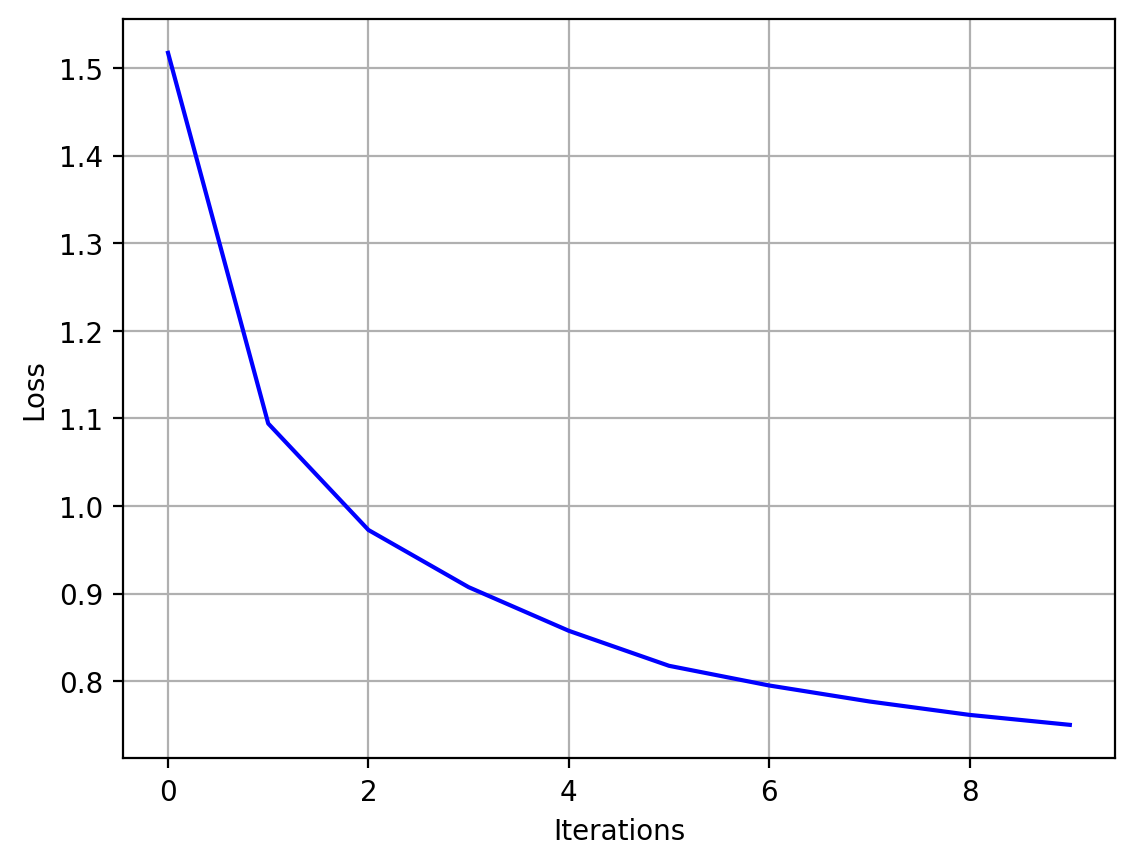

In [48]:
plt.plot(my_MLP.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

Wow! Performace is almost perfect with a naive Neural Network!!

> **Exercise:** Lets visualize the activations at the ouput of the first layer for a minibatch of test images. This will help to identify possible unused hidden units (always activated/deactivated) and correlated hidden units, e.g. redundant units. Complete the following code.

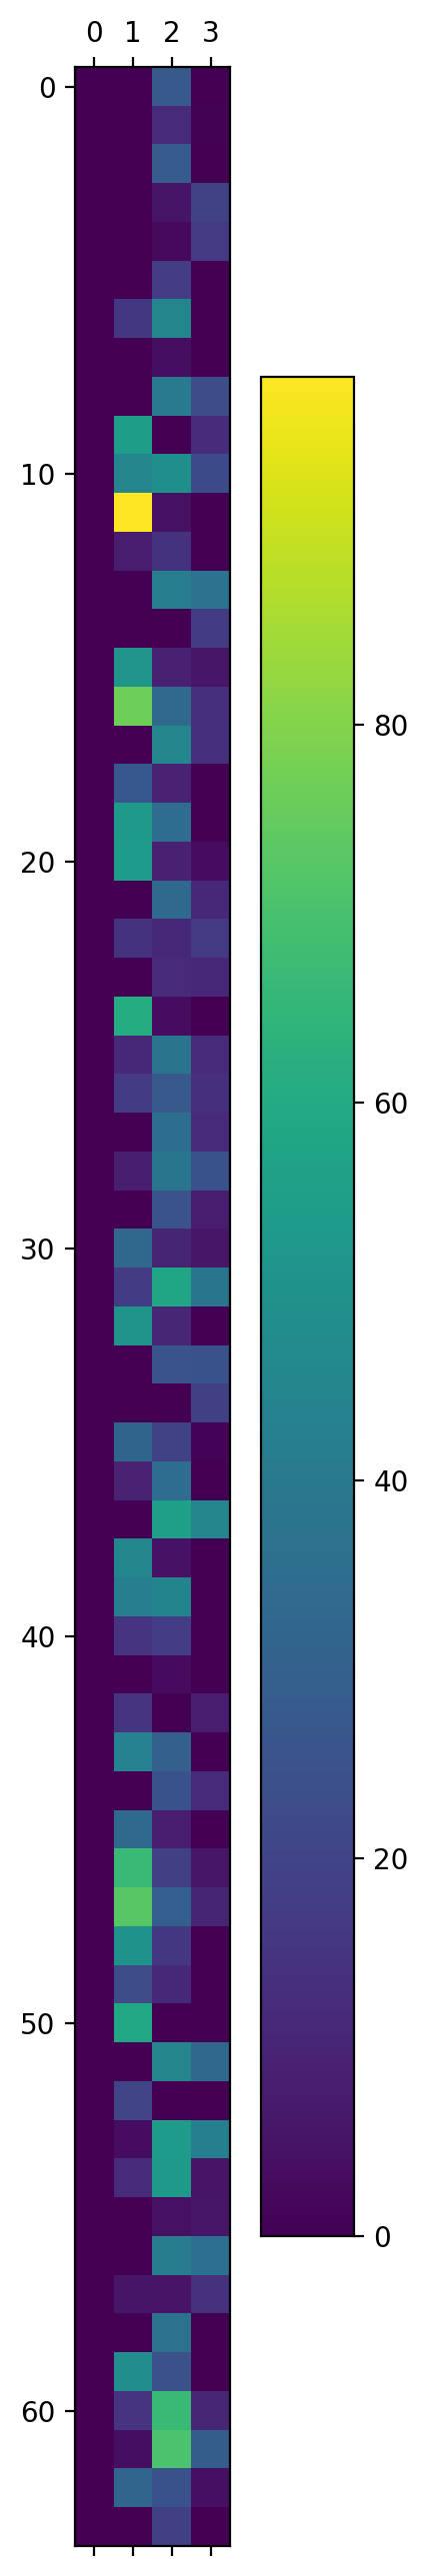

In [21]:
# First, we load a test minibatch

x_test,y_test = next(iter(testloader))

# Then, we evaluate the output of the first layer of the network for that mini-batch

activations = my_MLP.relu(my_MLP.output1(x_test.view([x_test.shape[0],-1]))).detach().numpy() # YOUR CODE HERE

# We plot the matrix using matplotlib

plt.matshow(activations)

plt.colorbar()


Based on the plot, do you think there are unsued hidden units in the hidden layer? They are characterized by units that are always active (very high values) or unactive (almost zero values). Plot the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units.

There are 1 hidden units that are unactive


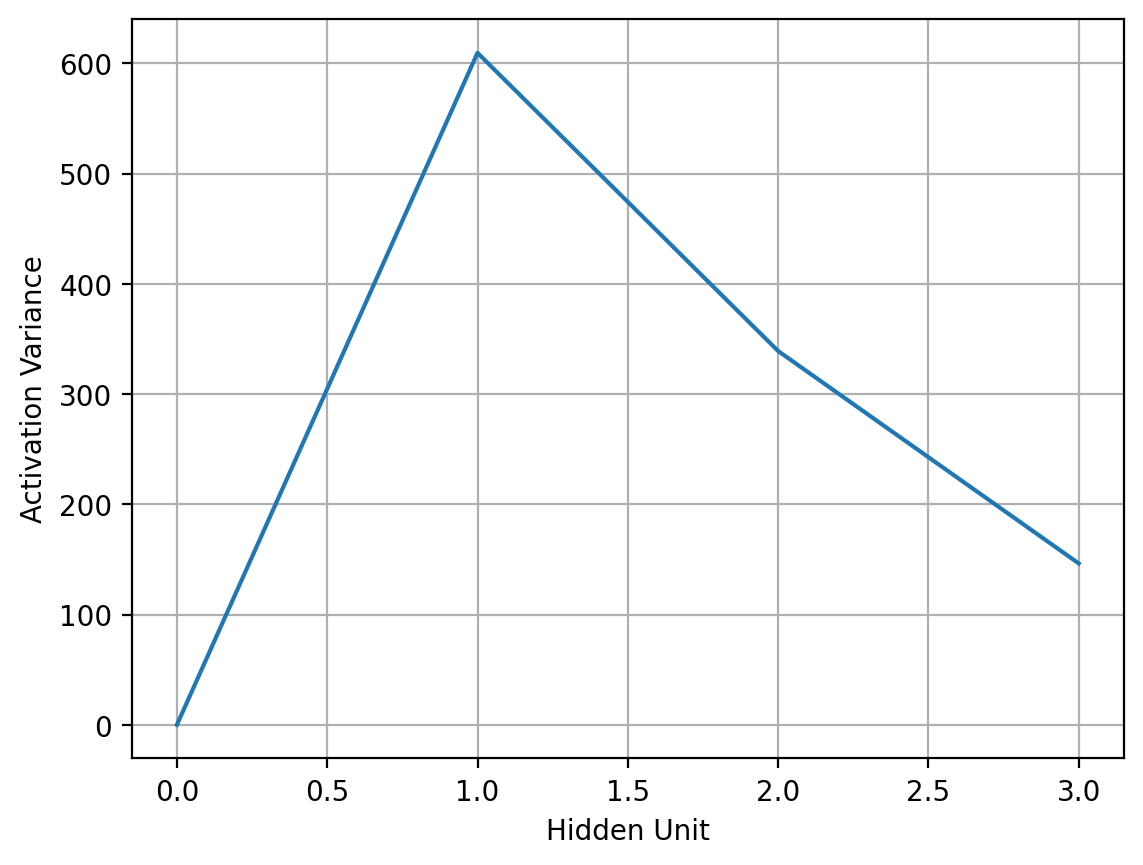

In [22]:
plt.plot(np.var(activations,0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

print("There are {0:d} hidden units that are unactive".format(np.sum(np.var(activations,0)<=0.1)))

> **Exercise**: Retrain the model reducing accordingly the dimension of the first hidden layer. For that model, repeat the analysis to the activations of both the first and the second layer.
>
>You will notice that in general, unsued activations are prominent in the first layer compared to the second one. This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more in the loss function), while many others vary very little w.r.t. initialization.

In [56]:
my_MLP_red = MLP_extended(dimx=784,hidden1=75,hidden2=64,nlabels=10,epochs=10,lr=1e-3)

my_MLP_red.train(trainloader)

train_performance = my_MLP_red.eval_performance(trainloader)

test_performance = my_MLP_red.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

ValueError: too many values to unpack (expected 2)

In the first layer, there are 32 hidden units that are unactive
In the second layer, there are 7 hidden units that are unactive


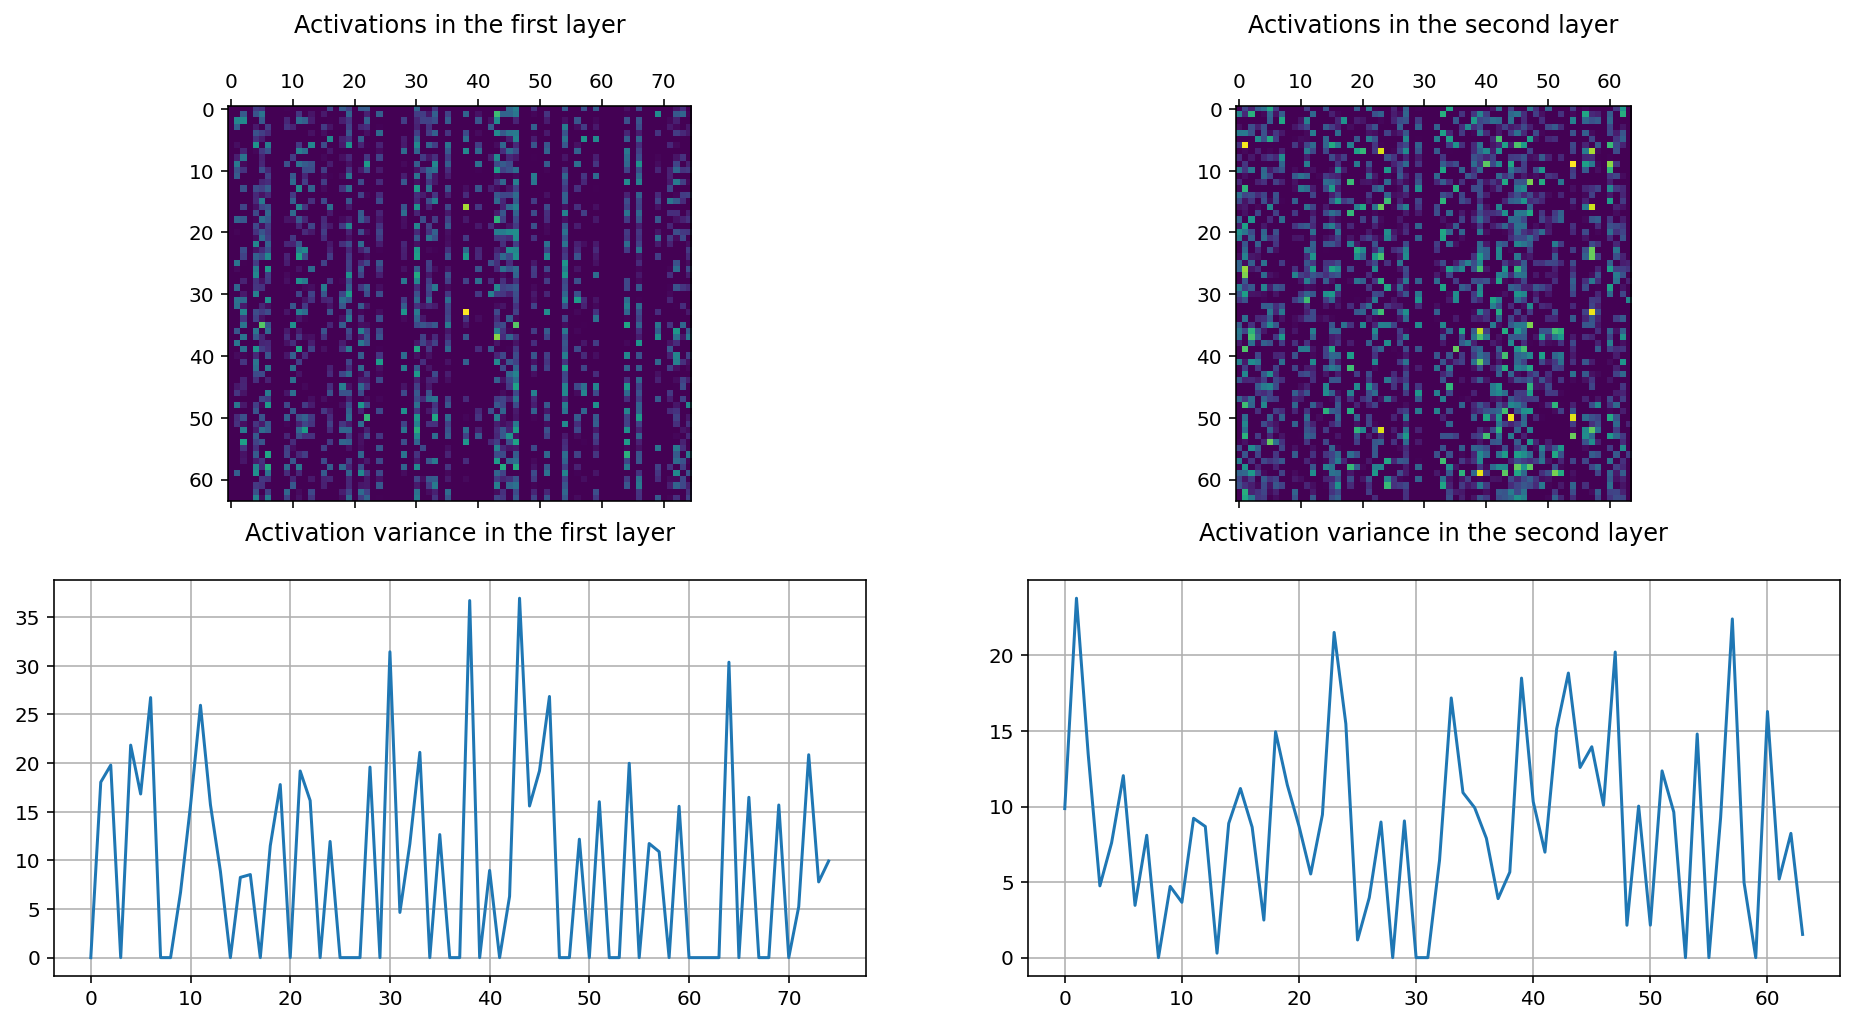

In [ ]:
activations_1 = my_MLP_red.relu(my_MLP_red.output1(x_test.view([x_test.shape[0],-1]))).detach().numpy() # YOUR CODE HERE

# Then, we evaluate the output of the first layer of the network for that mini-batch
activations_2 = my_MLP_red.relu(my_MLP_red.output2(my_MLP_red.relu(my_MLP_red.output1(x_test.view([x_test.shape[0],-1]))))).detach().numpy() # YOUR CODE HERE

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1)
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2)
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1,0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2,0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

print("In the first layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_1,0)<=0.1)))

print("In the second layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_2,0)<=0.1)))

> **Exercise**: Plot the histogram of the gradient of the loss function w.r.t. the parameters in the model for the first and the last layers and compare them.

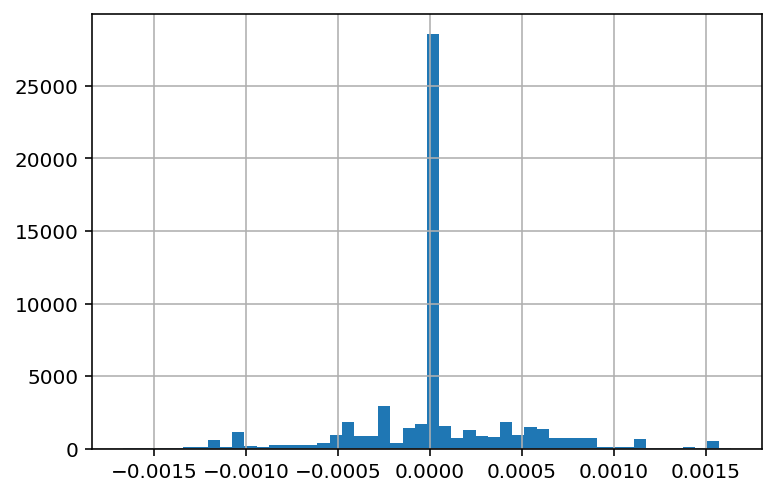

In [ ]:
# YOUR CODE HERE

plt.hist(my_MLP_red.output1.weight.grad.detach().numpy().reshape([-1,]),50)
plt.grid()



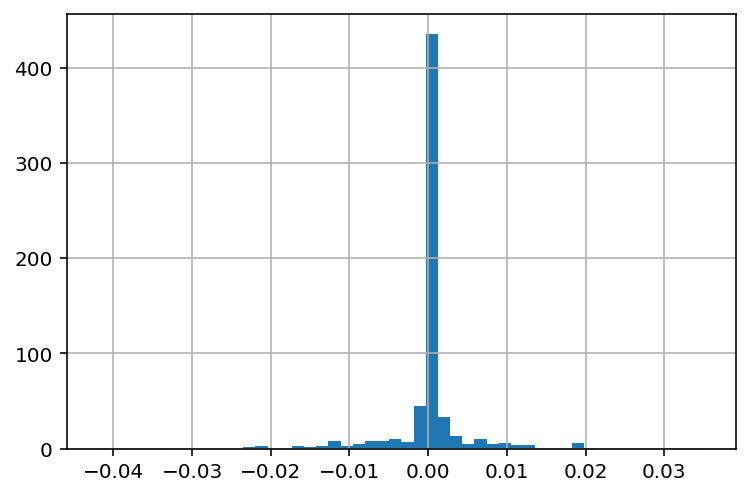

In [ ]:
plt.hist(my_MLP_red.output3.weight.grad.detach().numpy().reshape([-1,]),50)
plt.grid()

### Part IV. Saving and restoring the model

Finally, we will show you how to save and load models (i.e. values of the parameters) with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [ ]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Our model: 

 MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
) 

The state dict keys: 

 odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


The simplest thing to do is saving the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [ ]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


And to load the state dict in to the network, you do `my_MLP.load_state_dict(state_dict)`.

In [ ]:
my_MLP.load_state_dict(state_dict)

<All keys matched successfully>

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [ ]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> **Exercise:** Check that you get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [ ]:
my_MLP2.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for MLP_extended:
	size mismatch for output1.weight: copying a param with shape torch.Size([128, 784]) from checkpoint, the shape in current model is torch.Size([256, 784]).
	size mismatch for output1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for output2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for output3.weight: copying a param with shape torch.Size([10, 64]) from checkpoint, the shape in current model is torch.Size([10, 128]).